In [13]:
#libraries for clustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [14]:
df = pd.read_csv("B.HEALTH_classification.csv")
base_df = df.drop(columns=["subject","day"])

In [15]:
def cluster_ac(x, n_clusters):
    ac = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    ac.fit(x)
    return ac.labels_

In [89]:
def cluster_DBSCAN(x):
    db = DBSCAN(metric='euclidean', eps=1.8)
    db.fit(x)
    return db.labels_

In [90]:
def cluster_kmeans(x, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters).fit(x)
    return kmeans.labels_

In [91]:
def normalize_data(x, how='minmax'):
    match how:
        case 'minmax':
            scaler = MinMaxScaler()
            return scaler.fit_transform(x)
        case 'standard':
            scaler = StandardScaler()
            return scaler.fit_transform(x)
        case 'none':
            return x

In [92]:
def reduce_df(X, n_components=2, how='pca'):
    match how:
        case 'pca':
            redux = PCA(n_components)
            return redux.fit_transform(X)
        case 'tsne':
            redux = TSNE(n_components)
            return redux.fit_transform(X)
        case 'none':
            return X

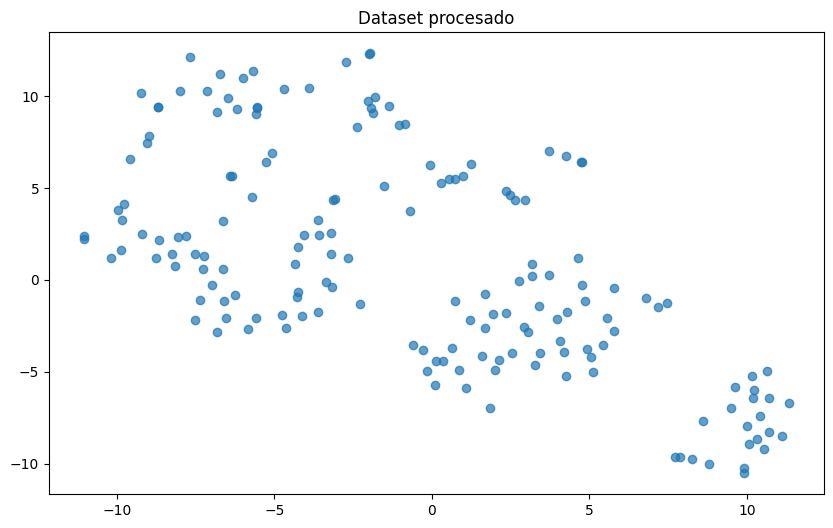

In [127]:
# Normalize the dataset
x_normalized = normalize_data(base_df, how='minmax')

# Reduce dimensions using TSNE
x_reduced = reduce_df(x_normalized, n_components=3, how='tsne')

x_reduced_plot = reduce_df(x_normalized, n_components=2, how='tsne')

# Scatter plot of the reduced data
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced_plot[:, 0], x_reduced_plot[:, 1], alpha=0.7)
plt.title('Dataset procesado')
plt.show()

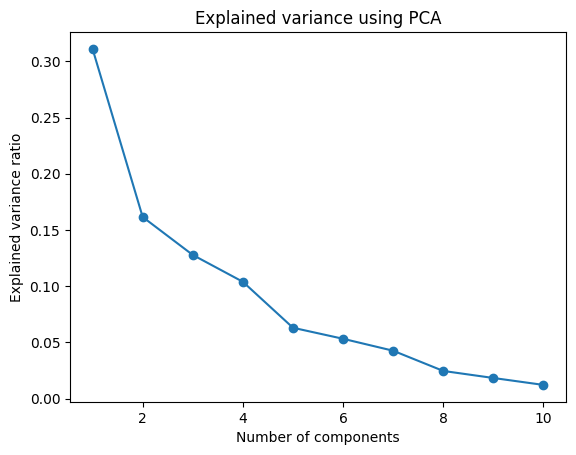

In [128]:
# Plot explained variance using PCA
pca = PCA(n_components=10)
pca_reduced = pca.fit_transform(x_normalized)
plt.plot(range(1, 11), pca.explained_variance_, marker='o')
plt.title('Explained variance using PCA')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')
plt.show()

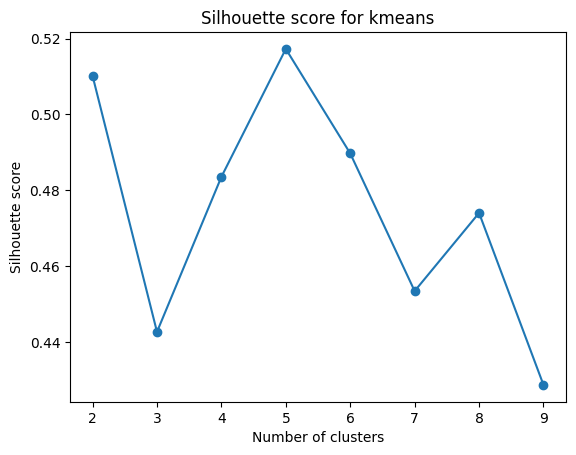

In [102]:
# Plot silhouette score for kmeans
silhouette_scores = []
for n_clusters in range(2, 10):
    kmeans_labels = cluster_kmeans(x_reduced, n_clusters=n_clusters)
    silhouette_avg = silhouette_score(x_reduced, kmeans_labels)
    silhouette_scores.append(silhouette_avg)
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette score for kmeans')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

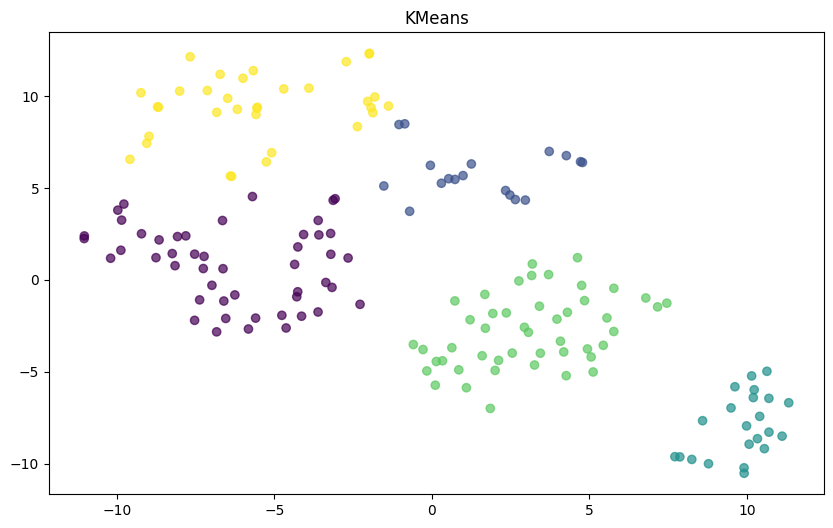

In [113]:
# Clusterize using KMeans
kmeans_labels = cluster_kmeans(x_reduced, n_clusters=5)

# Show the results
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=kmeans_labels, alpha=0.7)
plt.title('KMeans')
plt.show()

In [114]:
# Print the data of the instances of each cluster from Kmeans
for cluster_num in np.unique(kmeans_labels):
    print(f"Cluster {cluster_num}:")
    cluster_data = base_df[kmeans_labels == cluster_num]
    print(cluster_data)
    print("\n")


Cluster 0:
     step count  distance travelled (km)  calories burnt (kcal)  \
13         2319                     1.82                    749   
24         5867                     4.68                    348   
25         4972                     4.25                    259   
31         7107                     5.31                    175   
36         3392                     2.48                     77   
37         1057                     0.43                     23   
38          955                     0.39                     23   
39         1756                     0.72                     36   
40         2887                     1.18                     60   
41         1048                     0.36                     24   
42         2981                     1.39                     72   
43         2143                     1.01                     54   
44          840                     0.30                     19   
45         1000                     0.41           

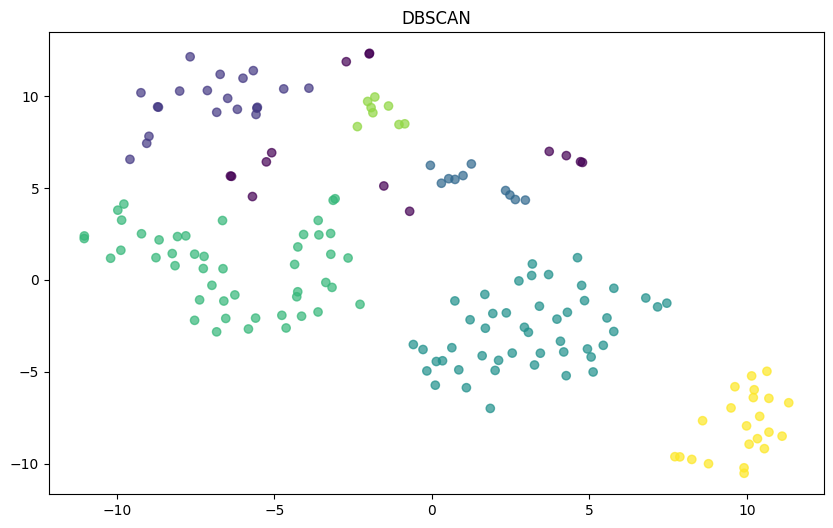

In [100]:
# Clusterize using DBSCAN
dbscan_labels = cluster_DBSCAN(x_reduced)

# Show the results
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=dbscan_labels, alpha=0.7)
plt.title('DBSCAN')
plt.show()

In [112]:
# Print the data of the instances of each cluster from DBSCAN
for cluster_num in np.unique(dbscan_labels):
    if cluster_num == -1:
        continue
    print(f"Cluster {cluster_num}:")
    cluster_data = base_df[dbscan_labels == cluster_num]
    print(cluster_data)
    print("\n")


Cluster 0:
    step count  distance travelled (km)  calories burnt (kcal)  \
0         3016                     2.28                   2151   
1         1790                     1.39                   2129   
2         2864                     2.07                   2032   
3         1419                     1.80                   1713   
4         1698                     1.30                   1725   
5         1722                     1.32                   1198   
6         2624                     2.01                   1320   
7         2214                     1.71                    703   
8         1592                     1.70                   1723   
9         5289                     3.92                   2122   
10        2515                     1.95                    890   
11        2726                     2.07                   1450   
12        2945                     3.09                   1564   
78        6633                     5.20                   2293   

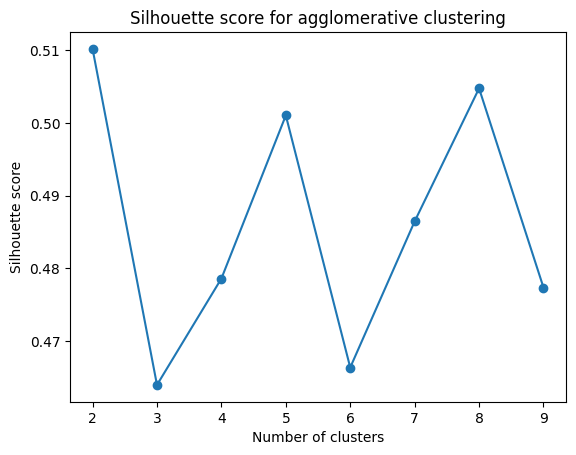

In [110]:
# Plot silhouette score for agglomerative clustering
silhouette_scores = []
for n_clusters in range(2, 10):
    agglomerative_labels = cluster_ac(x_reduced, n_clusters=n_clusters)
    silhouette_avg = silhouette_score(x_reduced, agglomerative_labels)
    silhouette_scores.append(silhouette_avg)
plt.plot(range(2, 10), silhouette_scores, marker='o')
plt.title('Silhouette score for agglomerative clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

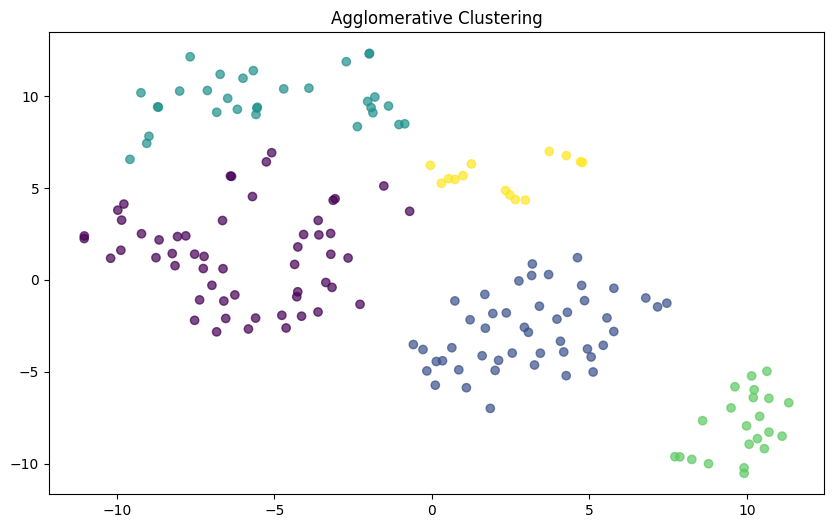

In [116]:
# Clusterize using agglomerative clustering
agglomerative_labels = cluster_ac(x_reduced, n_clusters=5)

# Show the results
plt.figure(figsize=(10, 6))
plt.scatter(x_reduced[:, 0], x_reduced[:, 1], c=agglomerative_labels, alpha=0.7)
plt.title('Agglomerative Clustering')
plt.show()

In [98]:
# Print the data of the instances of each cluster from agglomerative clustering
for cluster_num in np.unique(agglomerative_labels):
    print(f"Cluster {cluster_num}:")
    cluster_data = base_df[agglomerative_labels == cluster_num]
    print(cluster_data)
    print("\n")

Cluster 0:
     step count  distance travelled (km)  calories burnt (kcal)  \
0          3016                     2.28                   2151   
1          1790                     1.39                   2129   
2          2864                     2.07                   2032   
3          1419                     1.80                   1713   
4          1698                     1.30                   1725   
5          1722                     1.32                   1198   
6          2624                     2.01                   1320   
7          2214                     1.71                    703   
8          1592                     1.70                   1723   
9          5289                     3.92                   2122   
10         2515                     1.95                    890   
11         2726                     2.07                   1450   
12         2945                     3.09                   1564   
14         7011                     6.02           